In [1]:
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots

import pandas as pd
import xarray as xr
import seaborn as sns
import warnings
import logging
# sns.set()

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist

In [2]:
### Built sst_lagi
# # offset = 1
# sst = grs[-2].get_var_id_ds("sst")
# sst2 = sst.isel(days = slice(None, -offset))
# days2 = sst.days.values[offset:]
# sst2 = sst2.assign_coords(days=days2)

# # file = grs[-2].get_var_ds_file('sst')
# import os 

# file = f'/homedata/mcarenso/tempest/SAM_lowRes_Tropics/sst_lag{offset}.nc'
# os.remove(file)
# sst2.to_netcdf(file)

# funcs

In [13]:
import os
import pickle

def save_data(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def load_data(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def check_and_create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

In [14]:
from scipy.ndimage import gaussian_filter
from numpy import ma
from skimage.restoration import inpaint

def plot_smoothed_density_contours(density, levels=[0.2, 0.8], linestyle='-', linewidth = 2.0, fig=None, ax=None):
    # Example data array (replace this with your actual data array)
    data = density.T

    # Smooth data and handle NaN values
    masked_data = ma.masked_invalid(data)
    inpaint_mask = np.isnan(data)
    inpainted_data = inpaint.inpaint_biharmonic(data, inpaint_mask)
    smoothed_data = gaussian_filter(inpainted_data, sigma=2)
    smoothed_data = np.where(np.isnan(data), np.nan, smoothed_data)

    # Define contour levels
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    contours = ax.contour(smoothed_data, levels=levels, colors='black', linestyles=linestyle, linewidths=linewidth)
    ax.clabel(contours, inline=True, fontsize=8)

In [15]:
from matplotlib.colors import LinearSegmentedColormap


def plot_var_boundaries_on_jdist(self, var_id, func, boundaries, mask, stipple_threshold = 0.33, figsize = (5.35, 4.85), fig=None, ax=None, bar_bool = True, data = None):
    ## prepare data
    if "_lag1" in var_id or "_lag2" in var_id : 
        key = func+'_'+var_id[:3]
    else : 
        key = func+'_'+var_id
        
    if data is None:
        if func == 'MCS':
            da_var = self.grid.get_var_id_ds(self.st_label_var_id).sortby("days")[var_id]
        # Trying to avoid the prec bug, maybe it's due to prec dataset already being open within jd
        elif var_id == "Prec" : 
            da_var = self.prec.sortby("days")[key]
        else :  
            da_var = self.grid.get_var_id_ds(var_id).sortby("days")[key]
            
        var_days = list(da_var.days.values)
        if isinstance(mask, np.ndarray):
            mask  = mask[:,:,:len(var_days)] # adapt mask days length
        da_var = da_var.where(mask)
        var = da_var.values.ravel()

        reduced_prec = self.prec.sel(days = var_days)

        ## compute conditionalized data
        bincount_where_var_cond = []
        labels = []
        for cond_inf, cond_sup in zip(boundaries[:-1], boundaries[1:]):
            spatial_var_where_cond = list(np.where((da_var.values>cond_inf) & (da_var.values<=cond_sup)))
            # print([(spatial_var_where_cond[i]) for i in range(3)])
            sample1_where_cond = reduced_prec[self.var_id_1].where(mask).values[spatial_var_where_cond[0], spatial_var_where_cond[1], spatial_var_where_cond[2]] #this flattens
            sample2_where_cond = reduced_prec[self.var_id_2].where(mask).values[spatial_var_where_cond[0], spatial_var_where_cond[1], spatial_var_where_cond[2]] #this flattens
            bincount_cond, _, _ = np.histogram2d(x=sample1_where_cond, y=sample2_where_cond, bins = (self.bins1, self.bins2), density = False)
            bincount_where_var_cond.append(bincount_cond)
            labels.append(f"{cond_inf} < {key} <= {cond_sup}")

        # fetch proeminent boundaries and 2nd, then compute density difference between both 
        cond_stacked = np.stack(bincount_where_var_cond)
        cond_stacked = cond_stacked/np.sum(cond_stacked, axis = 0)

        data_layers = [data for data in cond_stacked]
        for data in data_layers:
            data[data < 0.5] = np.nan

    else : 
        data_layers = data

    # Define colormaps
    colormaps = [
        LinearSegmentedColormap.from_list("custom_blue", ["lavenderblush", "lightsteelblue",  "indigo"]),
        LinearSegmentedColormap.from_list("custom_red", ["honeydew", "forestgreen", "darkgreen"]),
        LinearSegmentedColormap.from_list("custom_green", ["seashell", "sandybrown", "darkred"])
    ]

    norms = [mpl.colors.BoundaryNorm([0.5, 0.6, 0.7, 0.8, 0.9, 1], colormap.N) for colormap in colormaps]

    labels = []
    for cond_inf, cond_sup in zip(boundaries[:-1], boundaries[1:]):
        labels.append(rf"[{np.round(cond_inf, 1)}K,{np.round(cond_sup, 1)}K]")
    texts = labels

    if ax is None : 
        fig, ax = plt.subplots(figsize=(4.85, 4.85))
    x = 0.93
    y = 0.11
    width = 0.02
    height = 0.7
    cax_positions = [[x, y, width, height], [x+0.03, y, width, height], [x+0.06, y, width, height]]

    for i, (data, colormap, norm, text) in enumerate(zip(data_layers, colormaps, norms, texts)):
        heatmap, cb, ax_show = self.plot_data(data, cmap=colormap, fig=fig, ax=ax, label = labels[i])
        cb = cb.remove()
        if bar_bool:
            cax = fig.add_axes(cax_positions[i])
            cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colormap), cax=cax, ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1], spacing='uniform')
            if i !=2 : cb.set_ticks([])  # Modify as needed
            cax.text(1.25, height+0.3, text, ha='center', va='bottom', transform=cax.transAxes, rotation=45)

    title = jd.name.split("_")[0]
    ax.set_title(title +" SST 2days earlier")
    ax.set_xlabel('$P$ ranks')
    ax.set_ylabel('$P_{0.15}$ ranks')

    return fig, ax, ax_show, data_layers
    

## FIG FINALE

In [16]:
# settings_path = 'settings/sam_4km_30min_30d.yaml'
# "settings/arpege_summer_30d.yaml",
#"settings/fv3_summer_30d.yaml"  ,
settings_paths = [ 
                    "settings/obs_summer_30d.yaml", 
                    "settings/arpege_summer_30d.yaml", 
                    "settings/mpas_summer_30d.yaml",  
                    "settings/sam_summer_30d.yaml"
                # 'settings/sam_4km_30min_30d.yaml'
                ]
# settings_paths = ["settings/nicam_summer_30d.yaml",  "settings/um_summer_30d.yaml"]
# settings_paths = [ "settings/sam_4km_30min_30d.yaml"]

hdlrs = [handler.Handler(settings_path) for settings_path in settings_paths]
css = [casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False) for hdlr in hdlrs]
grs = [grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False) for cs in css]
lm = grs[0].get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]
jds = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", 
        nbpd = 20,  nd=5, overwrite = True, dist_mask = False) for gr in grs]


Data loaded from /homedata/mcarenso/tempest/OBS_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /homedata/mcarenso/tempest/ARPEGE_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /homedata/mcarenso/tempest/MPAS_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /homedata/mcarenso/tempest/SAM_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /homedata/mcarenso/tempest/OBS_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /homedata/mcarenso/tempest/ARPEGE_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /homedata/mcarenso/tempest/MPAS_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /homedata/mcarenso/tempest/SAM_lowRes_Tropics/grid_attributes.pkl instead of computing


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/tmp/ipykernel_2052068/1262263767.py:42: RuntimeWarning: invalid value encountered in divide
  cond_stacked = cond_stacked/np.sum(cond_stacked, axis = 0)


KeyboardInterrupt: 

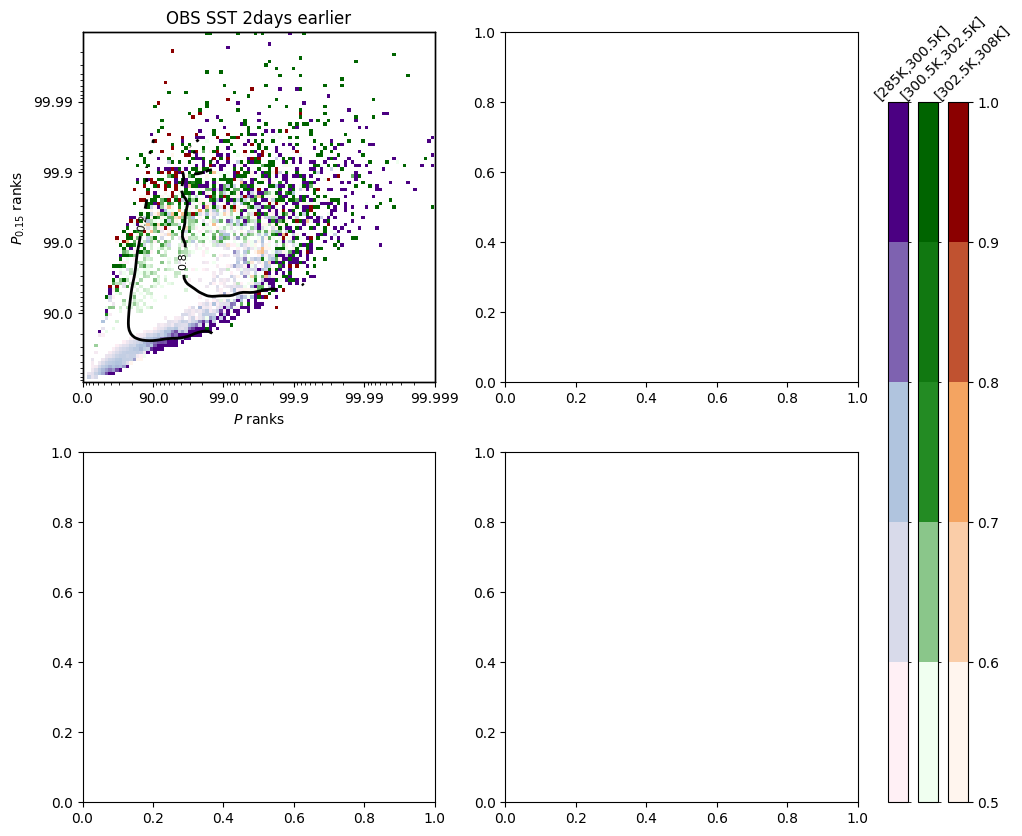

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
bar = True  # weird bar fix 

current_directory = os.getcwd()

overwrite = True 

for i, jd, ax in zip(range(len(jds)), jds, axs.flatten()):
    # if i == len(jds):  # Assuming you want to leave the last subplot blank
    #     ax.set_visible(False)
    #     continue    
    var_id = "sst_lag2"
    func = "mean"
    var_cond_list = [285, 300.5, 302.5, 308]  # var_cond_list = [285, 296, 301, 308]
    stipple_threshold = 0.2
    
    jd_directory = os.path.join(current_directory, "output", jd.name)
    check_and_create_directory(jd_directory)
    
    data_file_path = os.path.join(jd_directory, f"{var_id}_{func}_data_layers.pkl")
    density_vdcs_file_path = os.path.join(jd_directory, "vdcs_density.pkl")
    density_mcs_file_path = os.path.join(jd_directory, "mcs_density.pkl")
    
    if not overwrite and os.path.exists(data_file_path):
        data = load_data(data_file_path)
        fig, ax, ax_show, data = plot_var_boundaries_on_jdist(
            jd, var_id=var_id, func=func, boundaries=var_cond_list, mask=ocean,
            stipple_threshold=stipple_threshold, fig=fig, ax=ax, bar_bool=bar, data=data
        )
    else:
        fig, ax, ax_show, data = plot_var_boundaries_on_jdist(
            jd, var_id=var_id, func=func, boundaries=var_cond_list, mask=ocean,
            stipple_threshold=stipple_threshold, fig=fig, ax=ax, bar_bool=bar
        )
        save_data(data_file_path, data)
    
    if not overwrite and os.path.exists(density_vdcs_file_path):
        density_vdcs = load_data(density_vdcs_file_path)
    else:
        density_vdcs = jd.get_var_id_density_over_jdist(
            var_id="vdcs_cond_prec_15", func='intersection_over_half_intersection',
            mask=np.repeat(np.logical_or(~ocean, ocean), 30, axis=2)
        )
        save_data(density_vdcs_file_path, density_vdcs)
    
    plot_smoothed_density_contours(density_vdcs, levels=[0.2, 0.8], fig=fig, ax=ax_show)
    
    if not overwrite and os.path.exists(density_mcs_file_path):
        density_mcs = load_data(density_mcs_file_path)
    else:
        density_mcs = jd.get_var_id_density_over_jdist(
            var_id="mcs_cond_prec_15", func='intersection_over_half_intersection',
            mask=np.repeat(np.logical_or(~ocean, ocean), 30, axis=2)
        )
        save_data(density_mcs_file_path, density_mcs)
    
    plot_smoothed_density_contours(density_mcs, levels=[0.2, 0.8], linestyle="--", fig=fig, ax=ax_show)
    bar = False

# plt.tight_layout()
plt.show()

## FIG SUPPLEMENTARY 

In [ ]:
# settings_path = 'settings/sam_4km_30min_30d.yaml'
# "settings/arpege_summer_30d.yaml",
#"settings/fv3_summer_30d.yaml"  ,
settings_paths = [ 
                "settings/obs_summer_30d.yaml", 
                # "settings/arpege_summer_30d.yaml", 
                        "settings/fv3_summer_30d.yaml", "settings/ifs_summer_30d.yaml", 
                # "settings/mpas_summer_30d.yaml", 
                    "settings/nicam_summer_30d.yaml", 
                # "settings/sam_summer_30d.yaml", 
                    "settings/um_summer_30d.yaml",
                # 'settings/sam_4km_30min_30d.yaml'
                ]
# settings_paths = ["settings/nicam_summer_30d.yaml",  "settings/um_summer_30d.yaml"]
# settings_paths = [ "settings/sam_4km_30min_30d.yaml"]

hdlrs = [handler.Handler(settings_path) for settings_path in settings_paths]
css = [casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False) for hdlr in hdlrs]
grs = [grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False) for cs in css]
lm = grs[0].get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]
jds = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", 
        nbpd = 20,  nd=4, overwrite = True, dist_mask = False) for gr in grs]

Data loaded from /homedata/mcarenso/tempest/OBS_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /homedata/mcarenso/tempest/FV3_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /homedata/mcarenso/tempest/IFS_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /homedata/mcarenso/tempest/NICAM_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /homedata/mcarenso/tempest/UM_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /homedata/mcarenso/tempest/OBS_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /homedata/mcarenso/tempest/FV3_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /homedata/mcarenso/tempest/IFS_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /homedata/mcarenso/tempest/NICAM_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /homedata/mcarenso/tempest/UM

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/tmp/ipykernel_2247315/1262263767.py:42: RuntimeWarning: invalid value encountered in divide
  cond_stacked = cond_stacked/np.sum(cond_stacked, axis = 0)
/tmp/ipykernel_2247315/1262263767.py:42: RuntimeWarning: invalid value encountered in divide
  cond_stacked = cond_stacked/np.sum(cond_stacked, axis = 0)
/tmp/ipykernel_2247315/1262263767.py:42: RuntimeWarning: invalid value encountered in divide
  cond_stacked = cond_stacked/np.sum(cond_stacked, axis = 0)
/tmp/ipykernel_2247315/1262263767.py:42: RuntimeWarning: invalid value encountered in divide
  cond_stacked = cond_stacked/np.sum(cond_stacked, axis = 0)
/tmp/ipykernel_2247315/1262263767.py:42: RuntimeWarning: invalid value encountered in divide
  cond_stacked = cond_stacked/np.sum(cond_stacked, axis = 0)


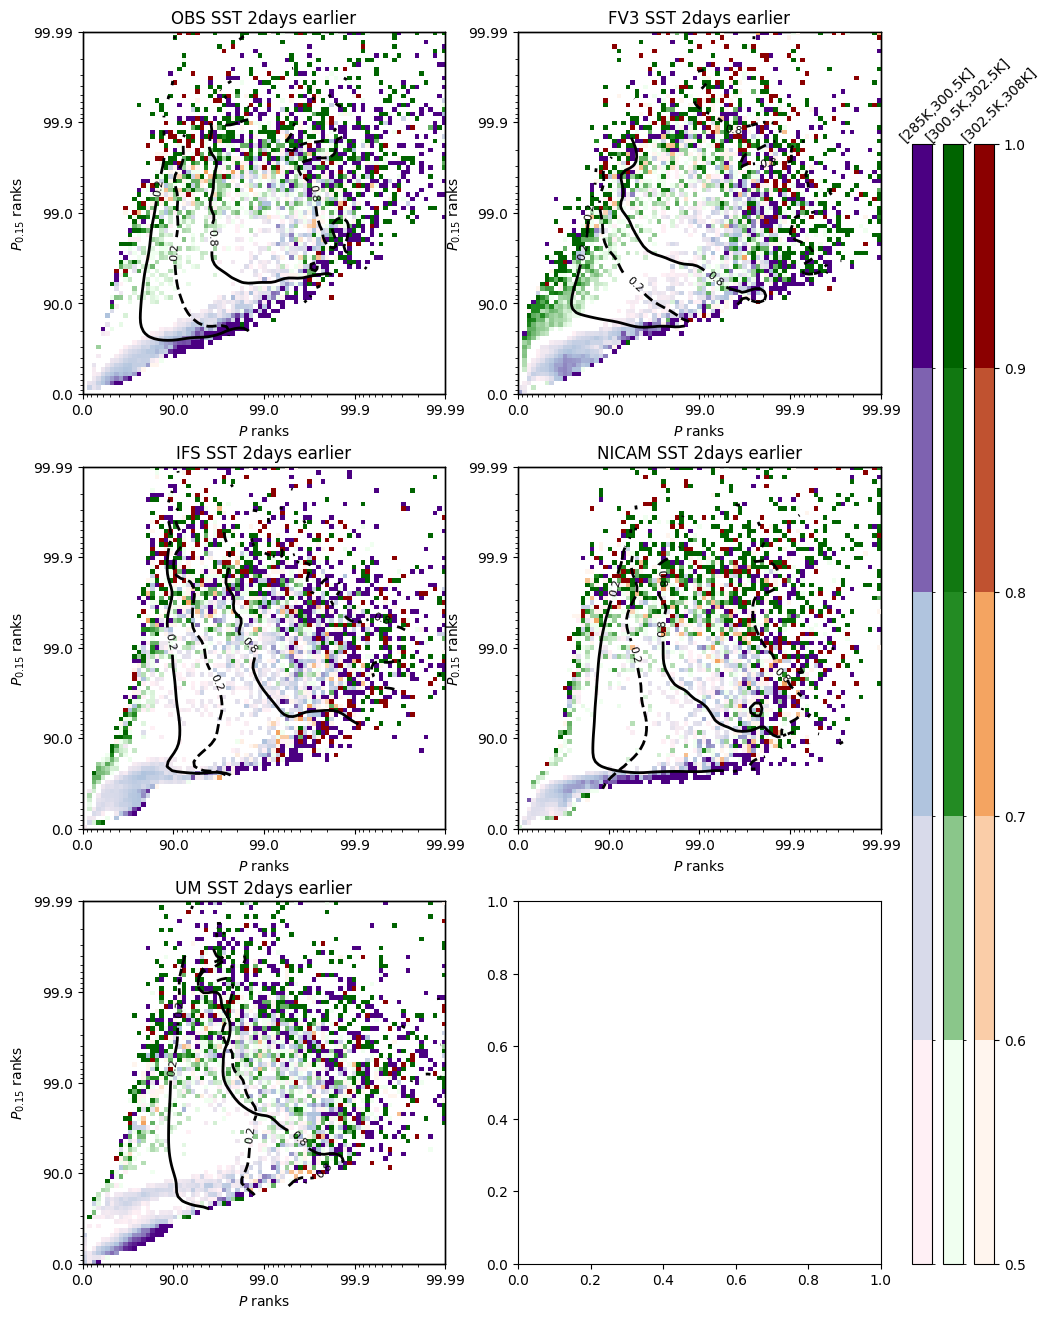

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10.3, 16))
bar = True  # weird bar fix 

current_directory = os.getcwd()

overwrite = True 

for i, jd, ax in zip(range(len(jds)), jds, axs.flatten()):
    if i == len(jds):  # Assuming you want to leave the last subplot blank
        ax.set_visible(False)
        continue    
    var_id = "sst_lag2"
    func = "mean"
    var_cond_list = [285, 300.5, 302.5, 308]  # var_cond_list = [285, 296, 301, 308]
    stipple_threshold = 0.2
    
    jd_directory = os.path.join(current_directory, "output", jd.name)
    check_and_create_directory(jd_directory)
    
    data_file_path = os.path.join(jd_directory, f"{var_id}_{func}_data_layers.pkl")
    density_vdcs_file_path = os.path.join(jd_directory, "vdcs_density.pkl")
    density_mcs_file_path = os.path.join(jd_directory, "mcs_density.pkl")
    
    if not overwrite and os.path.exists(data_file_path):
        data = load_data(data_file_path)
        fig, ax, ax_show, data = plot_var_boundaries_on_jdist(
            jd, var_id=var_id, func=func, boundaries=var_cond_list, mask=ocean,
            stipple_threshold=stipple_threshold, fig=fig, ax=ax, bar_bool=bar, data=data
        )
    else:
        fig, ax, ax_show, data = plot_var_boundaries_on_jdist(
            jd, var_id=var_id, func=func, boundaries=var_cond_list, mask=ocean,
            stipple_threshold=stipple_threshold, fig=fig, ax=ax, bar_bool=bar
        )
        save_data(data_file_path, data)
    
    if not overwrite and os.path.exists(density_vdcs_file_path):
        density_vdcs = load_data(density_vdcs_file_path)
    else:
        density_vdcs = jd.get_var_id_density_over_jdist(
            var_id="vdcs_cond_prec_15", func='intersection_over_half_intersection',
            mask=np.repeat(np.logical_or(~ocean, ocean), 30, axis=2)
        )
        save_data(density_vdcs_file_path, density_vdcs)
    
    plot_smoothed_density_contours(density_vdcs, levels=[0.2, 0.8], fig=fig, ax=ax_show)
    
    if not overwrite and os.path.exists(density_mcs_file_path):
        density_mcs = load_data(density_mcs_file_path)
    else:
        density_mcs = jd.get_var_id_density_over_jdist(
            var_id="mcs_cond_prec_15", func='intersection_over_half_intersection',
            mask=np.repeat(np.logical_or(~ocean, ocean), 30, axis=2)
        )
        save_data(density_mcs_file_path, density_mcs)
    
    plot_smoothed_density_contours(density_mcs, levels=[0.2, 0.8], linestyle="--", fig=fig, ax=ax_show)
    bar = False

# plt.tight_layout()
plt.show()

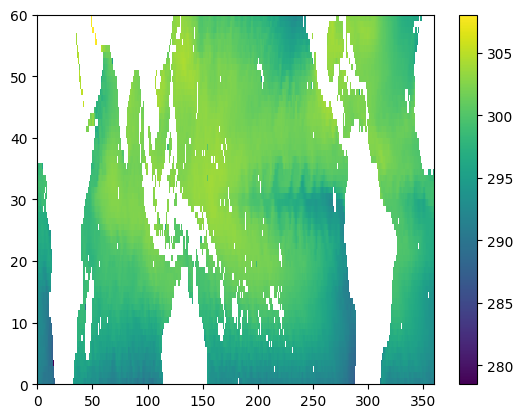

In [ ]:
sst = grs[-2].get_var_id_ds("sst").mean_sst.isel(days = 1).values
sst[~ocean[:,:,0]]=np.nan
plt.pcolormesh(sst)
# plt.pcolormesh(sst<290, alpha = 0.5)
plt.colorbar()

# Maybe use this map to see where some SST regimes comes from ? 

figure size = 15 3.25


/scratchx/mcarenso/ipykernel_1964126/2677763856.py:79: RuntimeWarning: invalid value encountered in divide
  mask_yxt_stacked = np.sum(mask_yxt_stacked, axis=-1) / np.sum(mask_yxt_stacked, axis=(0, -1))


Bbox(x0=0.439963768115942, y0=0.7126086956521739, x1=0.5850362318840581, y1=0.88)


/scratchx/mcarenso/ipykernel_1964126/2677763856.py:79: RuntimeWarning: invalid value encountered in divide
  mask_yxt_stacked = np.sum(mask_yxt_stacked, axis=-1) / np.sum(mask_yxt_stacked, axis=(0, -1))


Bbox(x0=0.439963768115942, y0=0.5117391304347826, x1=0.5850362318840581, y1=0.6791304347826087)


/scratchx/mcarenso/ipykernel_1964126/2677763856.py:79: RuntimeWarning: invalid value encountered in divide
  mask_yxt_stacked = np.sum(mask_yxt_stacked, axis=-1) / np.sum(mask_yxt_stacked, axis=(0, -1))


Bbox(x0=0.43996376811594207, y0=0.3108695652173913, x1=0.585036231884058, y1=0.47826086956521735)


/scratchx/mcarenso/ipykernel_1964126/2677763856.py:79: RuntimeWarning: invalid value encountered in divide
  mask_yxt_stacked = np.sum(mask_yxt_stacked, axis=-1) / np.sum(mask_yxt_stacked, axis=(0, -1))
/scratchx/mcarenso/ipykernel_1964126/2677763856.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Bbox(x0=0.439963768115942, y0=0.10999999999999999, x1=0.5850362318840581, y1=0.2773913043478261)


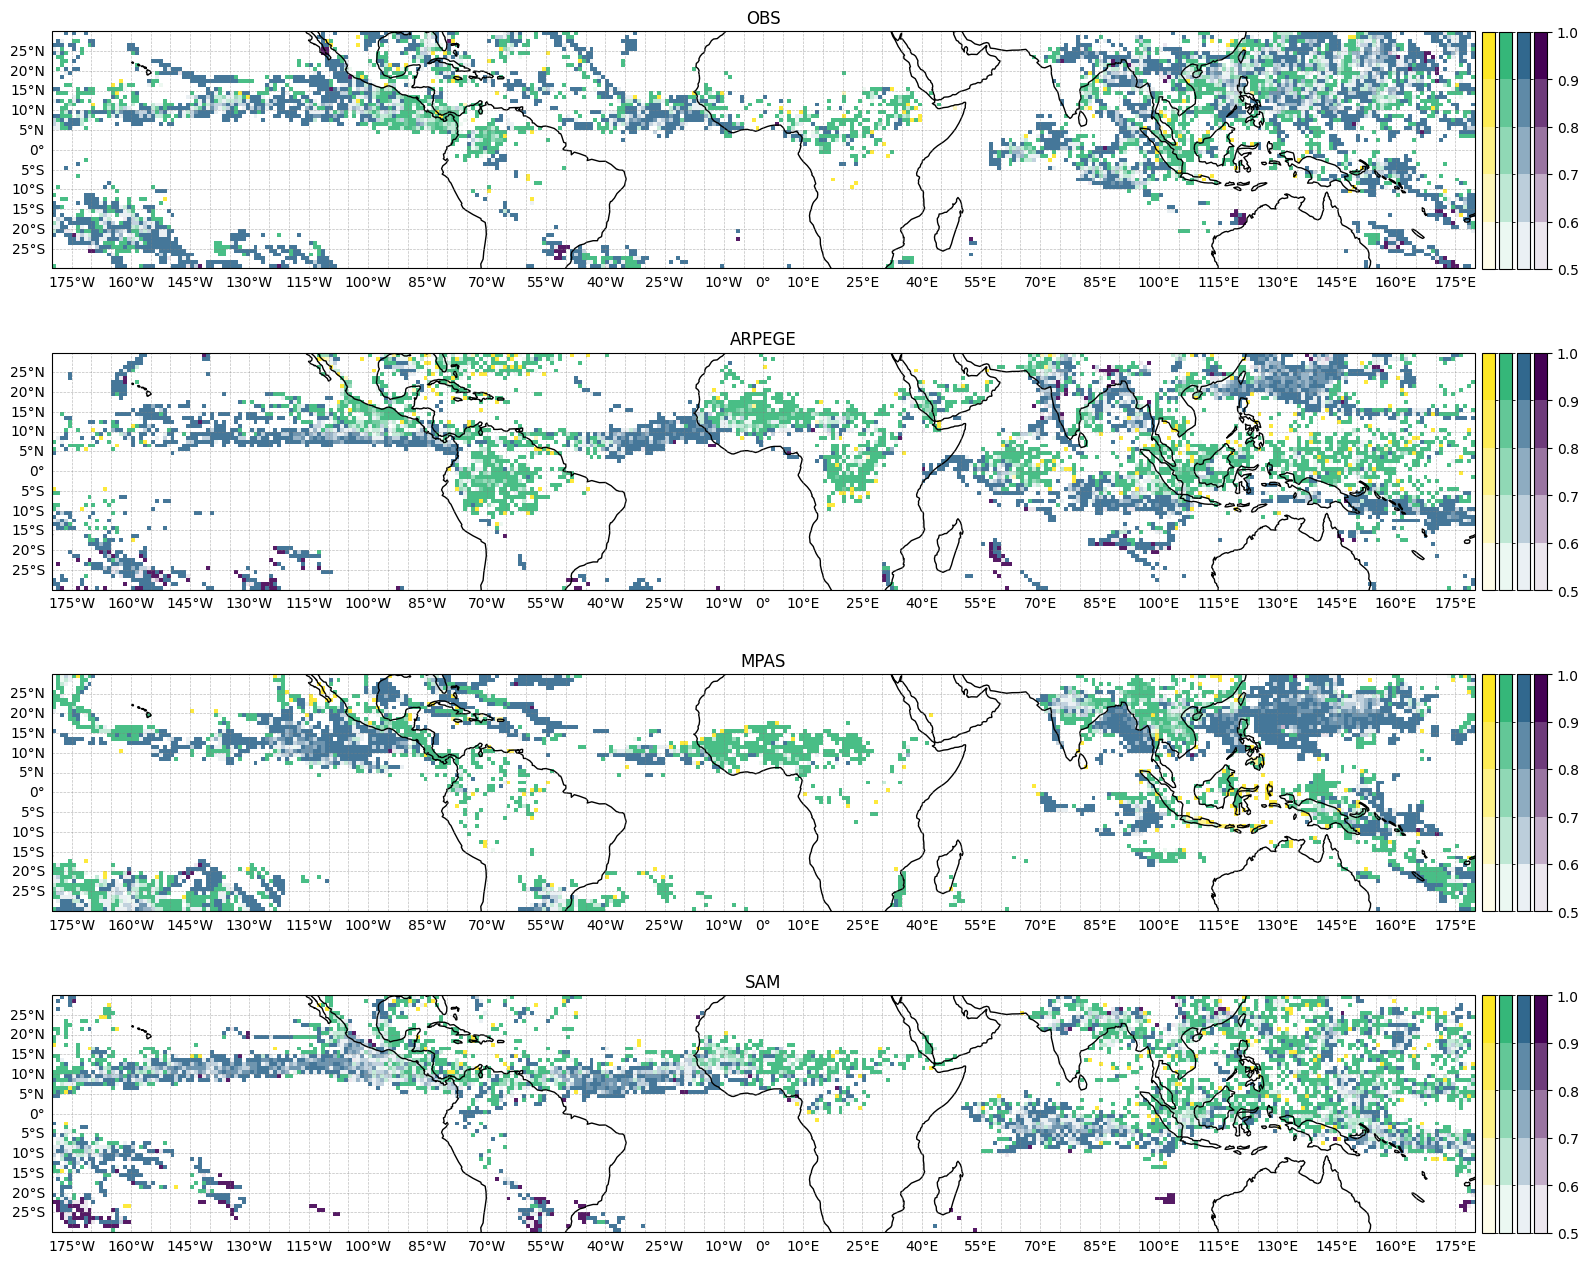

In [13]:
#### fig 3 maps 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import warnings
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

####################### This block defines the values and colormap #################################
values = np.array([1, 2, 3, 4])
cmap = mpl.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0.5, 5), cmap.N)

# Sample colors from the viridis colormap
colors = cmap(norm(values))

cmaps = []
def create_unicolor_colormap(base_color):
    # Create colors that start from white, transition to the base color, then to dark
    start = np.array([1, 1, 1, 1])  # white color
    end = np.array(base_color) # base color
    light_color = start + (end - start) * 0.1
    new_colors = [light_color * (1 - i) + end * i for i in np.linspace(0, 1, 256)]
    return mpl.colors.LinearSegmentedColormap.from_list("unicolor", new_colors)

for i, color in enumerate(colors[::-1]):
    new_cmap = create_unicolor_colormap(color)
    cmaps.append(new_cmap)
#####################################################################################################

colormaps = cmaps

# Norms (assuming same boundaries for simplification)
norms = [mpl.colors.BoundaryNorm([0.5, 0.6, 0.7, 0.8, 0.9, 1], colormap.N) for colormap in colormaps]

#### This block makes mask_all 
rank_conv_min = 99
rank_acc_min = 99
mask_alls =[]

# Assume jds is already defined and filled with the necessary data
figdir = '/figures/'

for jd in jds: 
    jd.make_mask()
    mask_rank_conv = np.outer(jd.dist1.ranks >= 0, jd.dist2.ranks >= rank_conv_min)
    mask_rank_acc = np.outer(jd.dist1.ranks >= rank_acc_min , jd.dist2.ranks >= 0)
    mask_alls.append([
        np.logical_and(jd.mask_branch1_90, mask_rank_conv), 
        np.logical_and(jd.mask_coloc_c_90, mask_rank_conv), 
        np.logical_and(jd.mask_coloc_ac_90, mask_rank_acc), 
        np.logical_and(jd.mask_branch2_90, mask_rank_acc)
    ])
####

# Calculate figure size based on jd grid
dlon = np.diff((jds[0].grid.casestudy.lon_slice.start, jds[0].grid.casestudy.lon_slice.stop))[0] % 360
if dlon == 0: dlon = 360
dlat = np.diff((jds[0].grid.casestudy.lat_slice.start, jds[0].grid.casestudy.lat_slice.stop))[0]
Lx_fig = 15
Lx_cbar = 1.5
Ly_title = 1
Ly_fig = (Lx_fig - Lx_cbar) / dlon * dlat + Ly_title
print('figure size =', Lx_fig, Ly_fig)

# Initialize figure with subplots
fig, axes = plt.subplots(len(jds), 1, figsize=(Lx_fig, Ly_fig * len(jds)), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

if len(jds) == 1:
    axes = [axes]

for jd, mask_all, ax in zip(jds, mask_alls, axes):
    list_mask_yxt = []
    for mask_ranked, cmap in zip(mask_all, cmaps):
        mask_yxt = jd.get_mask_yxt_from_mask_jdist(mask_ranked)
        list_mask_yxt.append(mask_yxt)
    mask_yxt_stacked = np.stack(list_mask_yxt)
    mask_yxt_stacked = np.sum(mask_yxt_stacked, axis=-1) / np.sum(mask_yxt_stacked, axis=(0, -1))
    data_layers = [data for data in mask_yxt_stacked]
    for data in data_layers:
        data[data < 0.5] = np.nan

    lat_1d = jd.get_coord_values('lat')
    lon_1d = jd.get_coord_values('lon')
    lon_meshgrid, lat_meshgrid = np.meshgrid(lon_1d, lat_1d)

    width = 0.06
    height = 1.09
    bottom = 0.1
    base_cax_positions = [[i-0.20, bottom, width, height] for i in [4, 4.08, 4.16, 4.24]]

    # Get the current axis position to adjust the cax positions accordingly
    pos = ax.get_position()
    print(pos)
    cax_positions = []

    for base_pos in base_cax_positions:
        cax_positions.append([
            pos.x0 + base_pos[0] * pos.width,
            1.23*(pos.y0-0.10)+0.025, #+ base_pos[1]* pos.height,
            base_pos[2] * pos.width,
            base_pos[3] * pos.height
        ])

    for i, (data, colormap, norm) in enumerate(zip(data_layers, colormaps, norms)):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            im = ax.pcolormesh(lon_meshgrid, lat_meshgrid, data, transform=ccrs.PlateCarree(), alpha=0.9, cmap=colormap, norm=norm)
        
        cax = fig.add_axes(cax_positions[i])
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colormap), cax=cax, ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1], spacing='uniform')
        if i != 3: 
            cb.set_ticks([]) 

    ax.set_title(jd.name[:-15])
    ax.coastlines('110m')
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator(range(-180, 181, 5))
    gl.ylocator = mticker.FixedLocator(range(-90, 91, 5))
    gl.top_labels = False  # Turn off labels on top x-axis
    gl.right_labels = False  # Turn off labels on right y-axis
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.tight_layout()

## Tweaked version to isolate SST scaling range

In [21]:
from matplotlib.colors import LinearSegmentedColormap

def plot_var_boundaries_on_jdist(self, var_id, func, boundaries, mask, stipple_threshold = 0.33, figsize = (5.35, 4.85), fig=None, ax=None, bar_bool = True):
    ## prepare data
    if "_lag1" in var_id or "_lag2" in var_id : 
        key = func+'_'+var_id[:3]
    else : 
        key = func+'_'+var_id
        
    if func == 'MCS':
        da_var = self.grid.get_var_id_ds(self.st_label_var_id).sortby("days")[var_id]
    # Trying to avoid the prec bug, maybe it's due to prec dataset already being open within jd
    elif var_id == "Prec" : 
        da_var = self.prec.sortby("days")[key]
    else :  
        da_var = self.grid.get_var_id_ds(var_id).sortby("days")[key]
        
    var_days = list(da_var.days.values)
    if isinstance(mask, np.ndarray):
        mask  = mask[:,:,:len(var_days)] # adapt mask days length
    da_var = da_var.where(mask)
    var = da_var.values.ravel()

    reduced_prec = self.prec.sel(days = var_days)

    ## compute conditionalized data
    bincount_where_var_cond = []
    labels = []
    for cond_inf, cond_sup in zip(boundaries[:-1], boundaries[1:]):
        spatial_var_where_cond = list(np.where((da_var.values>cond_inf) & (da_var.values<=cond_sup)))
        # print([(spatial_var_where_cond[i]) for i in range(3)])
        sample1_where_cond = reduced_prec[self.var_id_1].where(mask).values[spatial_var_where_cond[0], spatial_var_where_cond[1], spatial_var_where_cond[2]] #this flattens
        sample2_where_cond = reduced_prec[self.var_id_2].where(mask).values[spatial_var_where_cond[0], spatial_var_where_cond[1], spatial_var_where_cond[2]] #this flattens
        bincount_cond, _, _ = np.histogram2d(x=sample1_where_cond, y=sample2_where_cond, bins = (self.bins1, self.bins2), density = False)
        bincount_where_var_cond.append(bincount_cond)
        labels.append(f"{cond_inf} < {key} <= {cond_sup}")
    
    ## here is the tweak
    bincount_where_var_cond[0]+=bincount_where_var_cond[2]
    # fetch proeminent boundaries and 2nd, then compute density difference between both 
    cond_stacked = np.stack(bincount_where_var_cond[:-1])
    cond_stacked = cond_stacked/np.sum(cond_stacked, axis = 0)

    data_layers = [data for data in cond_stacked]
    for data in data_layers:
        data[data < 0.5] = np.nan

    # Define colormaps
    colormaps = [
        LinearSegmentedColormap.from_list("custom_blue", ["lavenderblush", "lightsteelblue",  "indigo"]),
        LinearSegmentedColormap.from_list("custom_red", ["honeydew", "forestgreen", "darkgreen"]),
        # LinearSegmentedColormap.from_list("custom_green", ["seashell", "sandybrown", "darkred"])
    ]

    norms = [mpl.colors.BoundaryNorm([0.5, 0.6, 0.7, 0.8, 0.9, 1], colormap.N) for colormap in colormaps]

    labels = []
    for cond_inf, cond_sup in zip(boundaries[:-1], boundaries[1:]):
        labels.append(rf"[{np.round(cond_inf, 1)}K,{np.round(cond_sup, 1)}K]")
    texts = labels

    if ax is None : 
        fig, ax = plt.subplots(figsize=(4.85, 4.85))
    x = 1
    y = 0.048
    height = 0.8
    cax_positions = [[x, y, 0.03, height], [x+0.04, y, 0.03, height], [x+0.08, y, 0.03, height]]

    for i, (data, colormap, norm, text) in enumerate(zip(data_layers, colormaps, norms, texts)):
        heatmap, cb, _ = self.plot_data(data, cmap=colormap, fig=fig, ax=ax, label = labels[i])
        cb = cb.remove()
        if bar_bool:
            cax = fig.add_axes(cax_positions[i])
            cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colormap), cax=cax, ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1], spacing='uniform')
            if i !=2 : cb.set_ticks([])  # Modify as needed
            cax.text(0.75, height+0.21, text, ha='center', va='bottom', transform=cax.transAxes, rotation=45)

    title = jd.name
    ax.set_title(title +' '+key)
    ax.set_xlabel('$P$ ranks')
    ax.set_ylabel('$P_{0.15}$ ranks')

/scratchx/mcarenso/ipykernel_1236627/756180900.py:42: RuntimeWarning: invalid value encountered in divide
  cond_stacked = cond_stacked/np.sum(cond_stacked, axis = 0)
/scratchx/mcarenso/ipykernel_1236627/756180900.py:42: RuntimeWarning: invalid value encountered in divide
  cond_stacked = cond_stacked/np.sum(cond_stacked, axis = 0)
/scratchx/mcarenso/ipykernel_1236627/756180900.py:42: RuntimeWarning: invalid value encountered in divide
  cond_stacked = cond_stacked/np.sum(cond_stacked, axis = 0)
/scratchx/mcarenso/ipykernel_1236627/756180900.py:42: RuntimeWarning: invalid value encountered in divide
  cond_stacked = cond_stacked/np.sum(cond_stacked, axis = 0)
/scratchx/mcarenso/ipykernel_1236627/756180900.py:42: RuntimeWarning: invalid value encountered in divide
  cond_stacked = cond_stacked/np.sum(cond_stacked, axis = 0)
/scratchx/mcarenso/ipykernel_1236627/756180900.py:42: RuntimeWarning: invalid value encountered in divide
  cond_stacked = cond_stacked/np.sum(cond_stacked, axis = 0

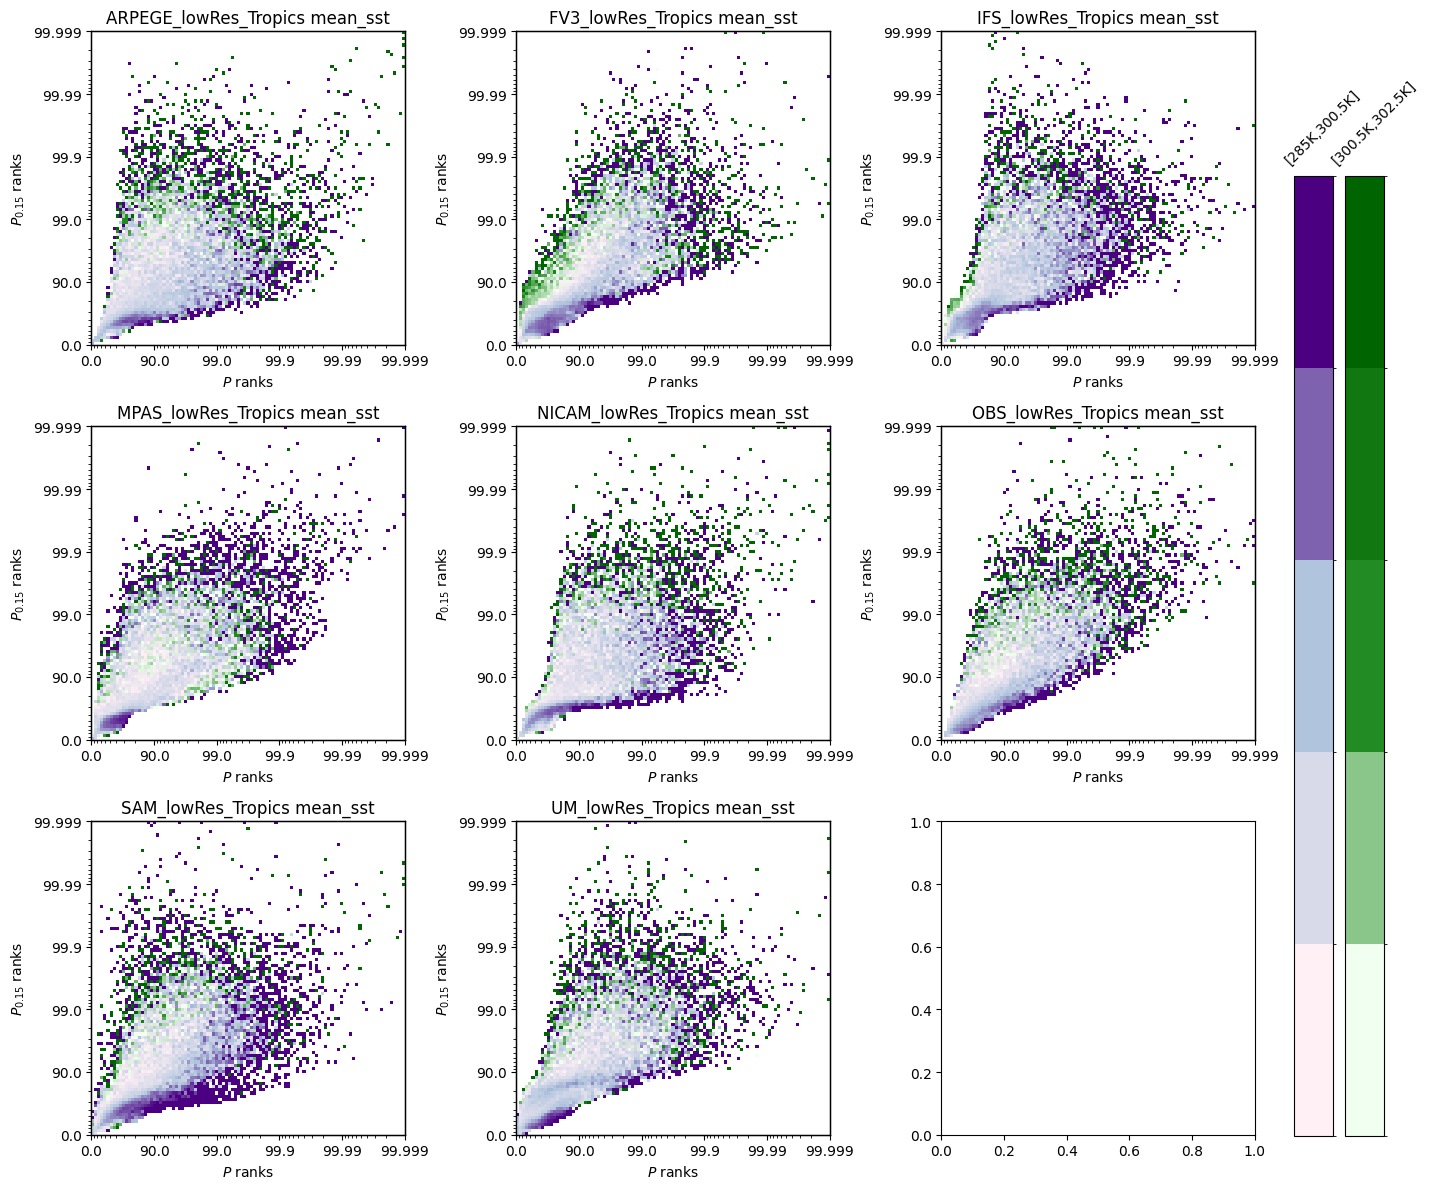

In [22]:
fig, axs = plt.subplots(3, 3,  figsize = (12.9, 1.5*len(jds)),)
bar = True #weird bar fix 
for i, jd, ax in zip(range(len(jds)), jds,axs.flatten()):
    var_id = "sst"
    func  = "mean"
    var_cond_list = [285, 300.5, 302.5, 308] #    var_cond_list = [285, 296, 301, 308]
    stipple_threshold = 0.2
    plot_var_boundaries_on_jdist(jd, var_id = var_id, func = func, boundaries = var_cond_list, mask = ocean, stipple_threshold=stipple_threshold, fig =fig, ax = ax, bar_bool = bar)
    bar = False
plt.tight_layout()

## check jds ranks percentiles value 